# Music Converter Notebook

CSI4106 Artificial Intelligence   
Prepared by:

## Introduction:
We start our project by first demonstrating with detailed notes how to decompose 1 song into features. Once this is complete, we will create a method which will repeat the process for 1000 songs.

### How the Notebook is Structured:
#### 1. Explain all 5 extracted features for 1 song.
#### 2. Show how to convert song to baseline csv form
#### 3. Show how to convert song to 5 feature csv form
#### 4. "FF. NN using Keras for a 5 feature song
#### 4a: Use Keras for baseline evaluation
#### 4b: Use keras for 3 feature eval.
#### 4c: Use Keras for 5 feature eval.
#### 5: Test our randomized hyperparameters
#### 6: Visualize all "main" keras results and discuss.

### Necessary Libraries
In order to run the following Notebook, the following libraries must first be installed:  
keras - https://keras.io/  
librosa - https://librosa.github.io/librosa/  
matplotlab - https://matplotlib.org/  
pandas - https://pandas.pydata.org/  
tensorflow (Requires Python 3.6) - https://www.tensorflow.org/  
  
To install, use the following commands:  
pip install keras  
pip install librosa  
pip install matplotlib  
pip install pandas  
pip install tensorflow

In [2]:
## Importing all necessary libraries
import librosa
import matplotlib.pyplot as plt
import librosa.display
import sklearn
import datetime
import keras
from keras import models
from keras import layers
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.collections import PolyCollection
import numpy as np
import csv
import pandas as pd
import math

Using TensorFlow backend.


## Part 1 - Explain all 5 extracted features for 1 song:
The following section demonstrates how the features are extracted from a song and what each one represents. It uses the first song from the dataset as an example.  
#### Step 1
The first step is to get the basic waveform of the song, which simply represents amplitude of sound over time.

This song is 30 seconds long.
The sampling rate of this file is: 22050. It represents how many times per second the audio is sampled.
The value "x" represents the wave form of a song, which contains 661504 slices.
The approximate duration of the song is: 30.00018140589569. Which is what we expect since all songs are 30 seconds long.


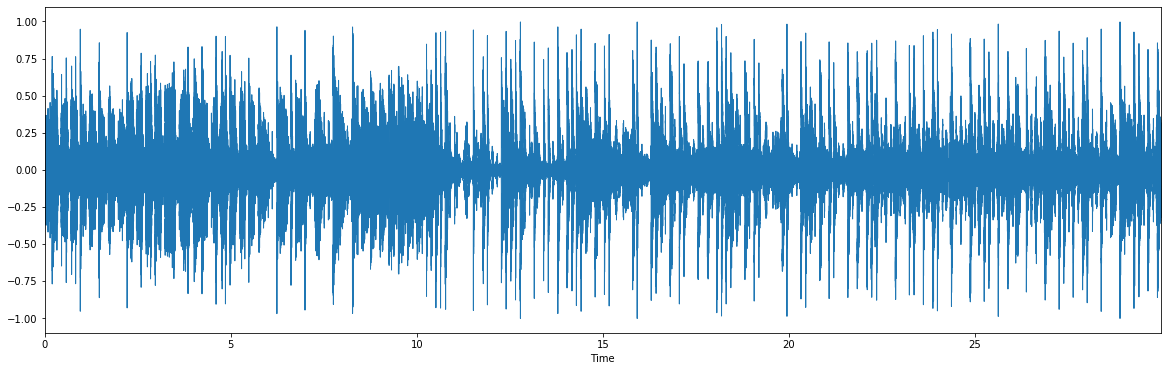

In [2]:
## Decomposing the first song in the Hip Hop folder into features

##### Step 1. Import the song file
print("This song is 30 seconds long.")
file_path = '../resources/genres/hiphop/hiphop.00000.wav'

## Load an audio file as a floating point time series.
x , sampling_rate = librosa.load(file_path)


print("The sampling rate of this file is: {0}. It represents how many times ".format(sampling_rate) +
      "per second the audio is sampled.")
print("The value \"x\" represents the wave form of a song, which contains {0} slices.".format(x.shape[0]))
print("The approximate duration of the song is: {0}. Which is what we expect since all songs are 30 seconds long.".format(len(x)/sampling_rate))

## Plot the waveform of the loaded file
plt.figure(figsize=(20, 6))
librosa.display.waveplot(x, sr=sampling_rate)



#### Step 2
The next step is to use librosa.stft() to decompose the waveform into its short-time Fourier Transform  
  
The STFT breaks down a signal into amplitude over time of each frequency. To demonstrate this more clearly, Figure 1 below shows a 3D spectrogram example from Wikipedia. To explain it more clearly, we'll take an example of a sound recording. The frequency axis represents all the possible frequencies in that recording. The time axis represents different times in the recording. The z or amplitude axis represents the amplitude (or level) of sound.

In the Figure, we can see that the amplitude of the low frequencies is also low. As the frequency gets higher, the amplitude also increases, meaning this recording was of a higher pitched sound.

The plots in the next section represent the same thing as Figure 1 and have the same frequency and time axis. However, instead of a third dimension for amplitude, they uses colour to show higher amplitudes across the 2D plane. 
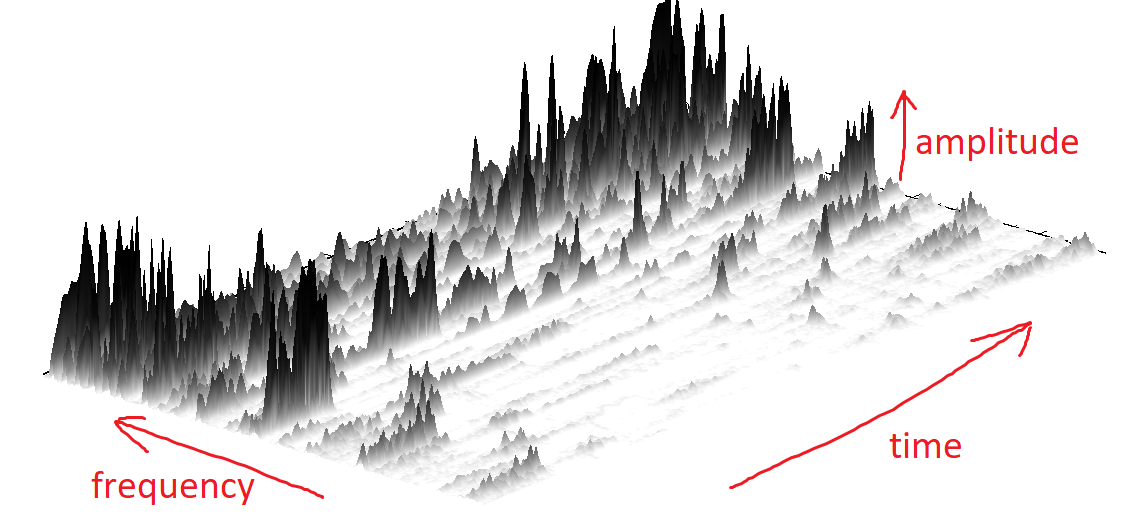
(Figure 1 Source:https://en.wikipedia.org/wiki/Spectrogram?fbclid=IwAR0Pzq_aS1hJtt-eEZxJyE1cZa6pEEKzYQBlhYer8x4CUOvHr_fOPkg89A8#/media/File:Spectrogram.png)

The following is a 3D representation of the previous spectrogram.


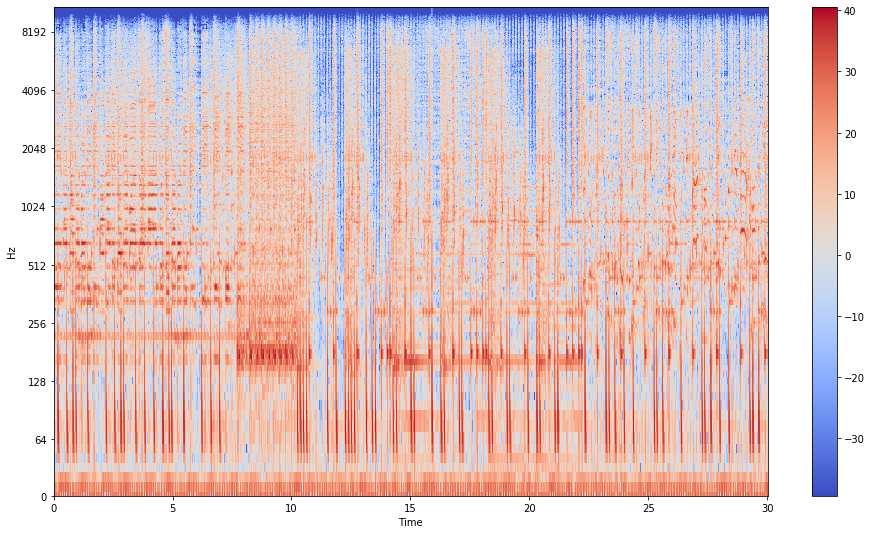

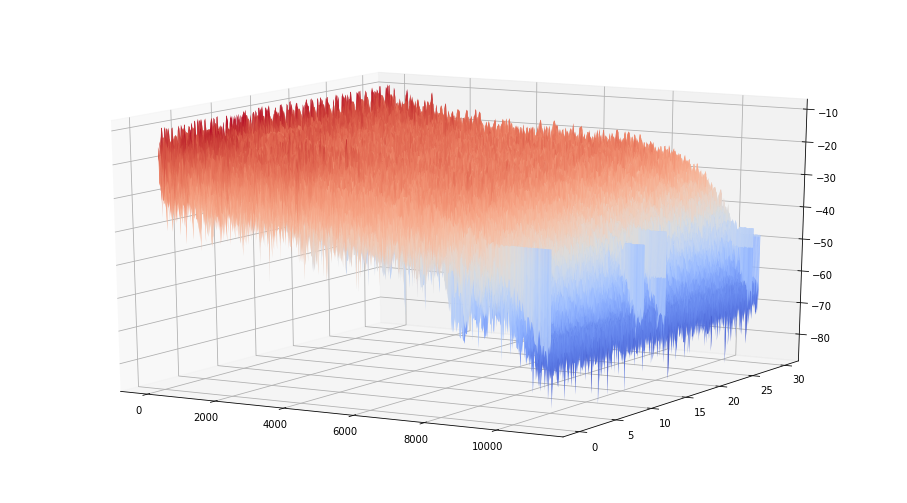

The following is a subset from 0-512Hz of the 3D spectogram.


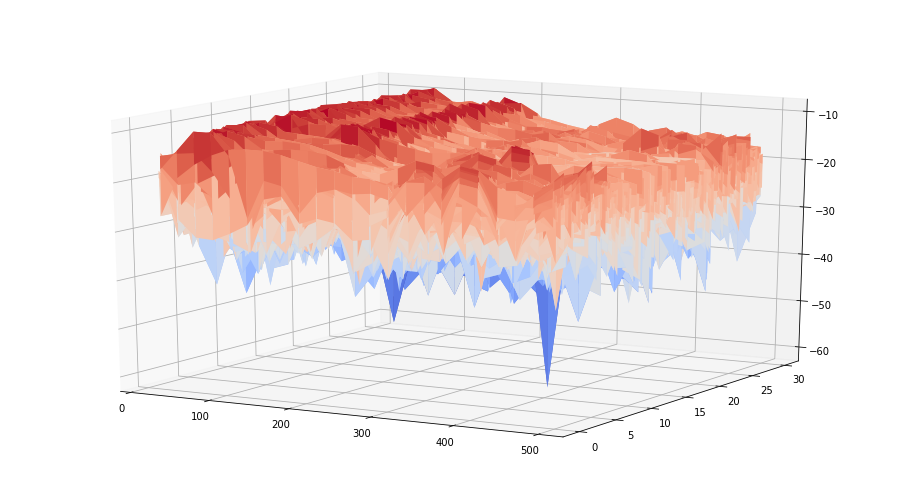

In [3]:
##### Step 2. Apply Short-Time Fourier Transform (STFT) to Decompose Wave Form to base frequencies

## This function converts our file into a time-frequency domain representation using short-time Fourier transform 
## (essentially this is the change of FFT's over time)
wav_form = librosa.stft(x)
S_spectogram, phase_spectogram = librosa.magphase(librosa.stft(y=x))

## Plot the spectrogram of the STFT representation
wav_form_db = librosa.amplitude_to_db(abs(wav_form))
plt.figure(figsize=(16,9))
librosa.display.specshow(wav_form_db, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar()
plt.ion()



##Ploting the 3D represenation spectrogram of the SFTF 
f, t, Zxx = signal.stft(x, sampling_rate, nperseg=1025)
Zxx=abs(Zxx)


fig = plt.figure(figsize=(16,9))
ax = fig.gca(projection='3d')
ax.plot_surface(f[:, None], t[None, :],10.0*np.log10(Zxx),rcount=2046, ccount=2046,cmap = cm.coolwarm)
ax.view_init(15, -60)
print ("The following is a 3D representation of the previous spectrogram.")
plt.show()

##Ploting the 3D represenation spectrogram of the SFTF in the frequence range of 0-512
myfilter = (f>000) & (f<512)
f = f[myfilter]
Zxx = Zxx[myfilter, ...]

fig = plt.figure(figsize=(16,9))
ax = fig.gca(projection='3d')
ax.plot_surface(f[:, None], t[None, :],10.0*np.log10(Zxx),rcount=2046, ccount=2046,cmap = cm.coolwarm)
ax.view_init(15, -60)
print ("The following is a subset from 0-512Hz of the 3D spectogram.")
plt.show()

##TODO:Add titles and axis for all the graphs. 

#### Step 3
Finally we can begin extracting our features. As mentioned before, we are using 5 distinct features: Zero-Crossing Rate, Spectral Centroid, Spectral Roll-off, Mel-Frequency Cepstral Coefficients (MFCC), Chroma Frequencies

From the image below which represents a small slice of time. The number of crossings 0 is 15 



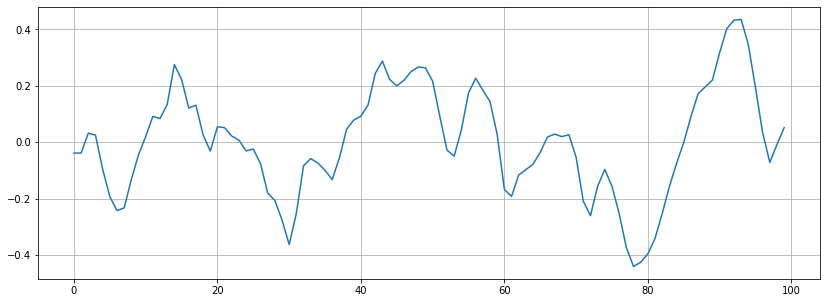

In [4]:
##### Step 3. Use the "wav_form_dB" decomposed song for Feature Extraction

# Feature 1: Zero-Crossing Rate 
## This represents how many times the frequency passes the "0" x-axis in either negative or positive direction
m0 = 10000
m1 = 10100
plt.figure(figsize=(14,5))
plt.plot(x[m0:m1])
plt.grid()
zero_crossing_sample = librosa.zero_crossings(x[m0:m1], pad=False)
print("From the image below which represents a small slice of time. The number of crossings " +
     "0 is {0} \n".format(sum(zero_crossing_sample)))
#print (zero_crossing_sample)

In [5]:
# Zero Crossing feature applied to entire song
zero_crossings = librosa.zero_crossings(x, pad=False)
print("When this idea of zero crossings is extended to the entire 30 second portion of a song, this song has " + 
      "{0} zero crossings".format(sum(zero_crossings)))

When this idea of zero crossings is extended to the entire 30 second portion of a song, this song has 97628 zero crossings


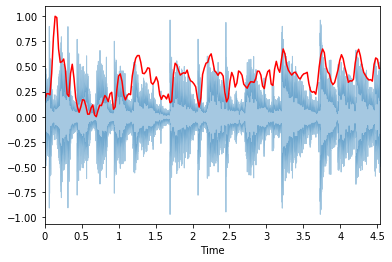

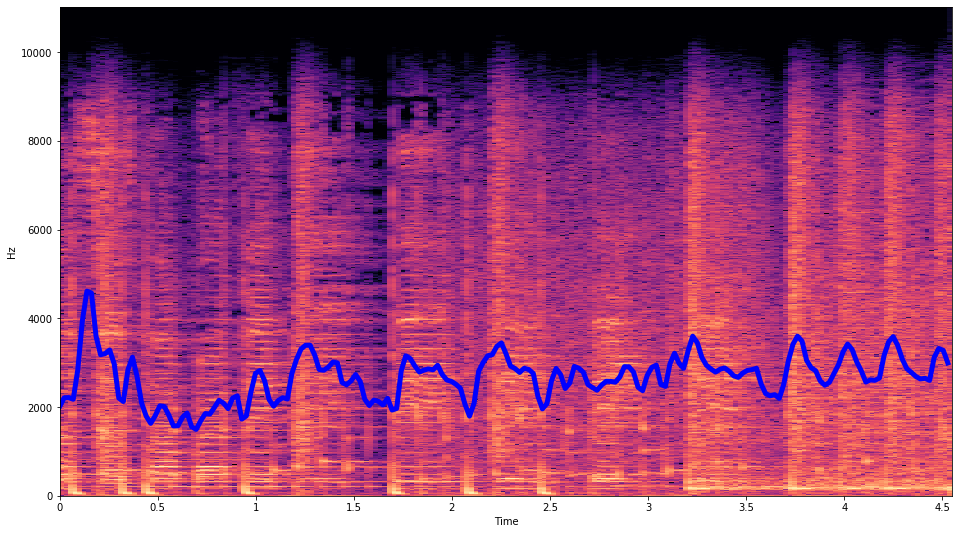

In [6]:
# Feature 2: Spectral Centroid 
## This feature represents taking a "slice" of a song and then taking the average of all frequencies at the
## point in time the slice represents. Extend this idea to ALL slices that make up a song, and
## using these averages plot a line that traverses exactly through each point, this is the Spectral Centroid
## of a song. This is important because two different genres may "generally" have a different spectral centroid line.

# Smaller Sample taken for demonstration below
n0 = 100000
n1 = 200000
x_sample = x[n0:n1]
spectral_centroids_sample = librosa.feature.spectral_centroid(x_sample, sr=sampling_rate)[0]
spectral_centroids_sample.shape

frames = range(len(spectral_centroids_sample))
t = librosa.frames_to_time(frames)

# Normalize
def normalize(x_sample, axis=0):
    return sklearn.preprocessing.minmax_scale(x_sample, axis=axis)

librosa.display.waveplot(x_sample, sr=sampling_rate, alpha=0.4)
plt.plot(t, normalize(spectral_centroids_sample), color='r')

## Alternative representations



##TODO: add appropriate plot titles 

S_sample, phase_sample = librosa.magphase(librosa.stft(y=x_sample))
plt.figure(figsize = (16,9))
librosa.display.specshow(librosa.amplitude_to_db(S_sample, ref=np.max),y_axis='hz', x_axis='time')
plt.plot(t,spectral_centroids_sample, lw = 5.0, color='b')




## TODO: Add comment to describe code above. Change code above slightly also.
## TODO: Add comment describing image below.

In [7]:
# Full song taken as spectral_centroid

spectral_centroids = librosa.feature.spectral_centroid(x, sr=sampling_rate)[0]
print(spectral_centroids.shape)

(1293,)


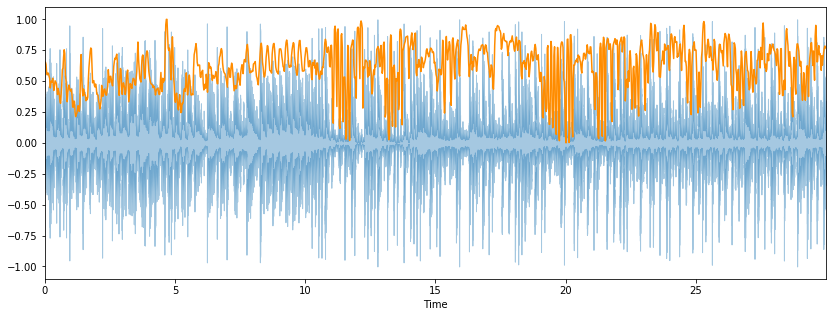

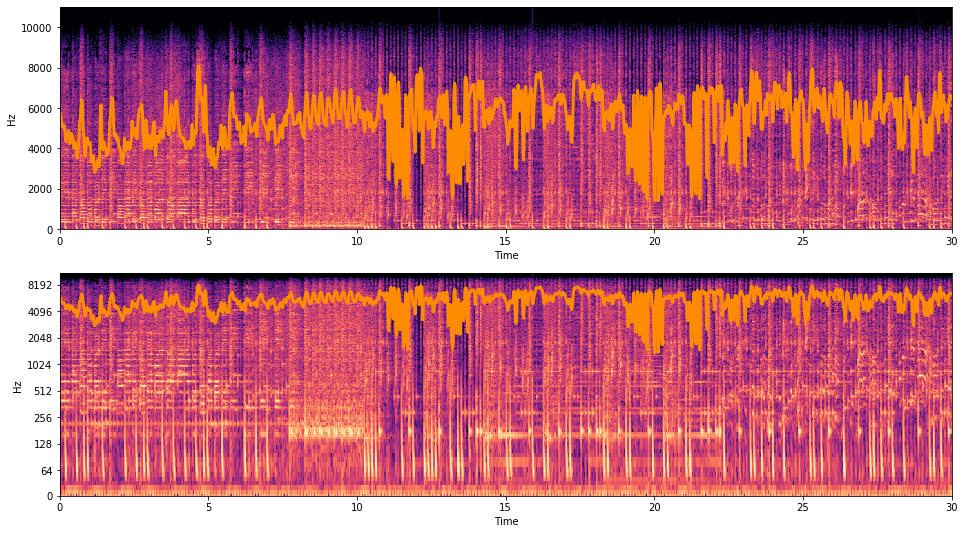

(1293,)


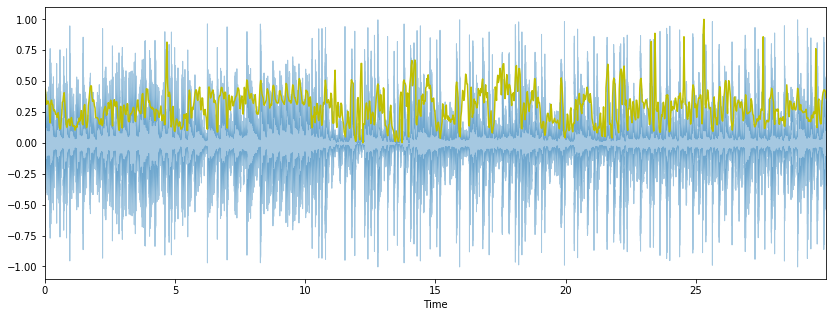

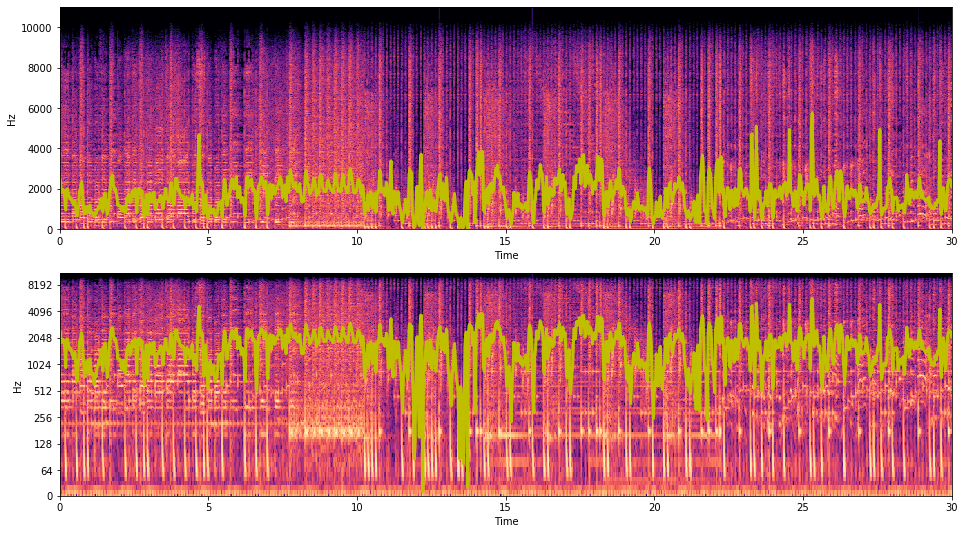

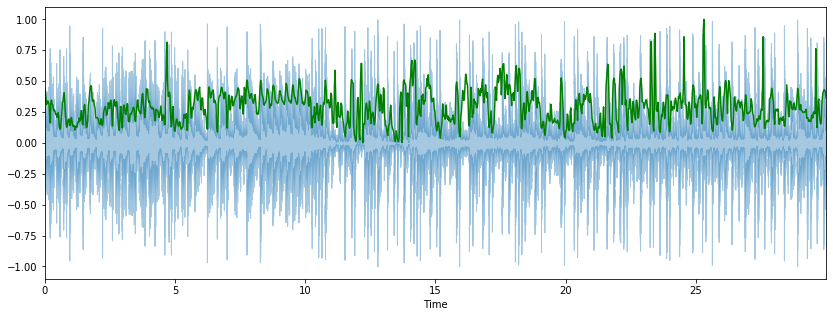

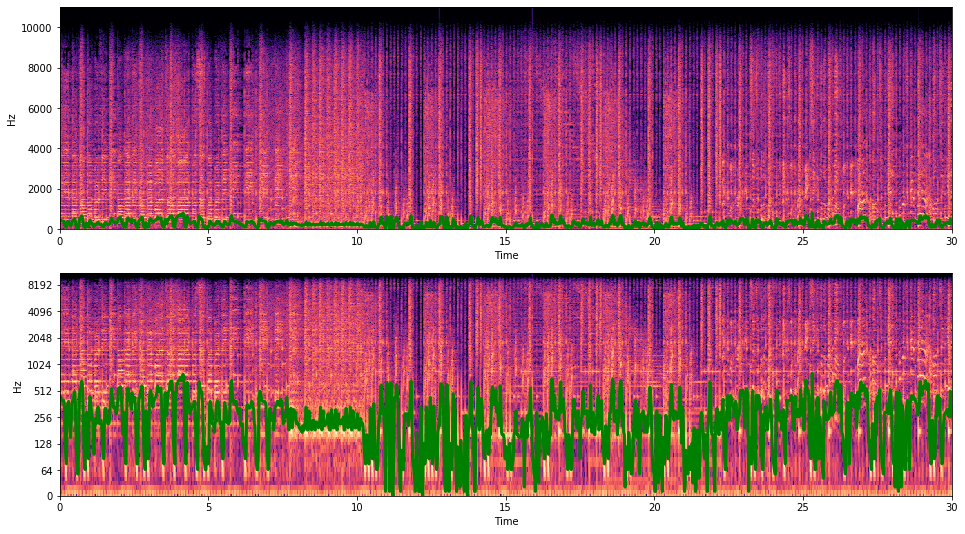

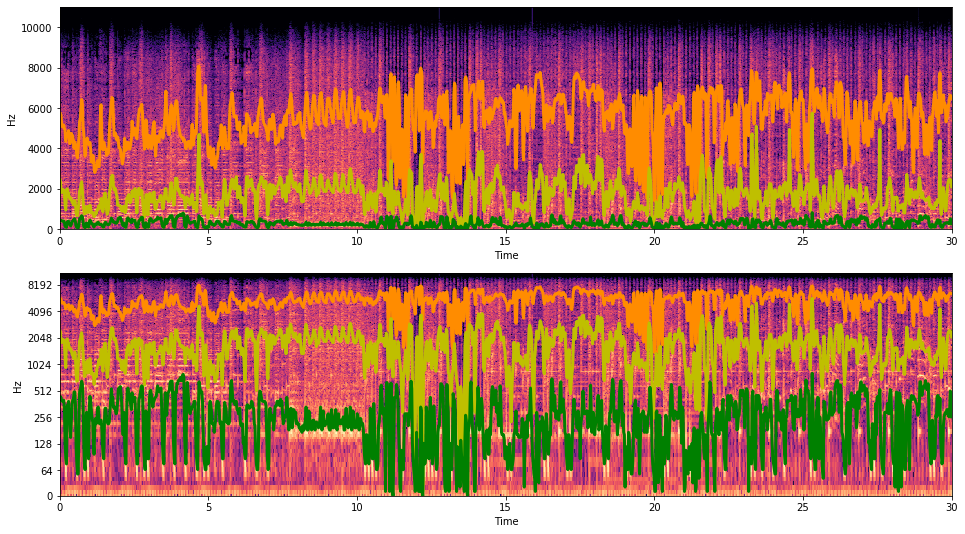

In [8]:
# Feature 3: Spectral Roll-off
## For a single slice of the stft the total "Energy" of all frequencies the it is composed of is always equal
## to "100%". Spectral-Roll off finds the frequency at which a certain given percentage of the energy is. For
## example, the Spectral Roll-Off at 85% of a song might be at 6000Hz. To find this value, it adds these composite
## frequencies in order of highest frequencies in terms of Hz, to lower frequencies. This approach is applied to the
## entire song at each slice which ends up creating a series of points on a graph that are joined together by a line
## passing directly through all points to create the Spectral Roll-off.




# Smaller Sample taken for demonstration below
## Spectral Roll Percent at 85% 



spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sampling_rate, roll_percent=0.85)[0]

frames = range(len(spectral_rolloff))
t = librosa.frames_to_time(frames)

plt.figure(figsize=(14,5))
librosa.display.waveplot(x, sr=sampling_rate, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='darkorange')


plt.figure(figsize = (16,9))
plt.subplot(2,1,1)
librosa.display.specshow(librosa.amplitude_to_db(S_spectogram, ref=np.max),y_axis='hz', x_axis='time')
plt.plot(t,spectral_rolloff, color='darkorange', lw=3)
plt.subplot(2,1,2)
librosa.display.specshow(librosa.amplitude_to_db(S_spectogram, ref=np.max),y_axis='log', x_axis='time')
plt.plot(t,spectral_rolloff, color='darkorange', lw=3)
plt.show()



print(spectral_rolloff.shape)

## Spectral Roll Percent at 45%
spectral_rolloff_2= librosa.feature.spectral_rolloff(x+0.01, sr=sampling_rate, roll_percent=0.45)[0]
plt.figure(figsize=(14,5))
librosa.display.waveplot(x, sr=sampling_rate, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff_2), color='y')

plt.figure(figsize = (16,9))
plt.subplot(2,1,1)
librosa.display.specshow(librosa.amplitude_to_db(S_spectogram, ref=np.max),y_axis='hz', x_axis='time')
plt.plot(t,spectral_rolloff_2, color='y', lw=3)
plt.subplot(2,1,2)
librosa.display.specshow(librosa.amplitude_to_db(S_spectogram, ref=np.max),y_axis='log', x_axis='time')
plt.plot(t,spectral_rolloff_2, color='y', lw=3)
plt.show()

## Spectral Roll Percent at 10%
spectral_rolloff_3= librosa.feature.spectral_rolloff(x+0.01, sr=sampling_rate, roll_percent=0.1)[0]
plt.figure(figsize=(14,5))
librosa.display.waveplot(x, sr=sampling_rate, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff_2), color='g')

plt.figure(figsize = (16,9))
plt.subplot(2,1,1)
librosa.display.specshow(librosa.amplitude_to_db(S_spectogram, ref=np.max),y_axis='hz', x_axis='time')
plt.plot(t,spectral_rolloff_3, color='g', lw=3)
plt.subplot(2,1,2)
librosa.display.specshow(librosa.amplitude_to_db(S_spectogram, ref=np.max),y_axis='log', x_axis='time')
plt.plot(t,spectral_rolloff_3, color='g', lw=3)
plt.show()

#Plotting the 3 different rolloffs percentages on the same graph both on a linear hz scale and a log hz scale
plt.figure(figsize = (16,9))
plt.subplot(2,1,1)
librosa.display.specshow(librosa.amplitude_to_db(S_spectogram, ref=np.max),y_axis='hz', x_axis='time')
plt.plot(t,spectral_rolloff, color='darkorange', lw=3)
plt.plot(t,spectral_rolloff_2, color='y', lw=3)
plt.plot(t,spectral_rolloff_3, color='g', lw=3)
plt.subplot(2,1,2)
librosa.display.specshow(librosa.amplitude_to_db(S_spectogram, ref=np.max),y_axis='log', x_axis='time')
plt.plot(t,spectral_rolloff, color='darkorange', lw=3)
plt.plot(t,spectral_rolloff_2, color='y', lw=3)
plt.plot(t,spectral_rolloff_3, color='g', lw=3)
plt.show()
##TODO: Explain difference in the 3 graphs and add labels and axis 

##TODO: Add spectral reprisentation to the roll off frequency as an alternative data visualization IOT synch with feature 2 
## and to add extra from the DS post. 

(20, 1293)


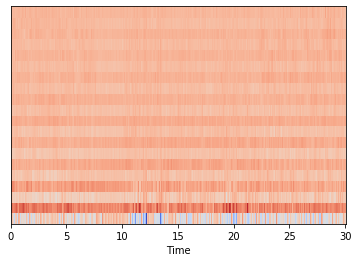

In [9]:
# Feature 4: Mel-Frequency Cepstral Coefficients (MFCC)
## This feature represents:This feature is a way to represent human auditory sounds

mfccs = librosa.feature.mfcc(x, sr=sampling_rate)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sampling_rate, x_axis='time')

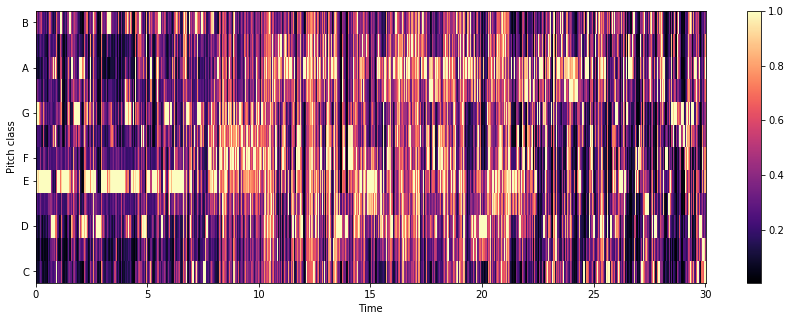

In [10]:
# Feature 5: Chroma Frequencies
## This feature represents: This will will divide the spectrum in to 12 distinct semitones that represent that
## represent a musical octave, for the entire song.

chromagram = librosa.feature.chroma_stft(x, sr=sampling_rate )
plt.figure(figsize=(15,5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma')
plt.colorbar()



## Part 2 - Convert song to baseline csv form & read values
In this section, we convert all 1000 songs from the dataset into their waveforms and store them in a CSV file (included in the Project folder). Storing them in a CSV means we won't have to complete this step every time the program is closed and reopened and also allows for easy access.  
  
For each song, we take a 5, 10, and 20 second waveform. These will be used later to compare how the length of a sample affects the accuracy.

In [10]:
## baseline_waveform_512_subset extracts the waveform of each song. To do so, it loads the song and then takes the average
## value for every 512 sample points and creates one point for them, thus compressing the sample to a more manageable size.
## It is possible to simply take a different sampling rate by passing the parameter to the load() function, however, we
## wanted to know exactly how it was being resampled and there is limited documentation about resampy's ‘kaiser_best’.
## After compressing, we add the new sample point to the list wave_form_downsize and continue iterating through until the
## entire song has been sampled.

def baseline_waveform_512_subset(songFilePath,startTime,duration):
    x , sampling_rate = librosa.load(songFilePath, offset= startTime, duration=duration)
    wave_form_downsize = []
    start_point = 0

    for i in range (0,(math.floor(x.shape[0]/512))):
        sum_512=0.0
        for j in range (start_point, start_point + 512):
            sum_512+=x[j]
        wave_form_downsize.append(float(sum_512/512))
        start_point+=512
    return wave_form_downsize
    

## Create a csv file into which the sampled waveform will be written. The file will include a column for the filename,
## genre, and each of the sampled values.
def csvCreatorBaseline (file_name,size):
    header_elements =["filename "]
    for l in range (1, size+1):
        header_elements.append(f' waveform slice {l}')
    header_elements.append('genre')
    file = open(file_name,'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header_elements)
        
## CSV Appendor Method for adding the extrated music feautres to the CSV File. Appends the sampled values into the CSV
## file.
def csvAppendorBaseline (csvFile_name, waveform_512_split, song_file_path, genre):
    to_append =f'{song_file_path}'
    to_append += " "
    for i in range(0,len(waveform_512_split)):
        to_append += str(waveform_512_split[i])
        to_append +=" "
    to_append += " "
    to_append += genre
    file = open(csvFile_name, 'a', newline='')  
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())
        

In [12]:
## Calculates how many sample points each file will have. The number of sample points will depend on the length of the
## sample chosen and we have decided to take 5, 10, and 20 second samples of each song in order to compare how they 
## perform. Since each is sampled at the same rate, the longer samples will have more points.
second_5=math.floor((5*22050)/512)
second_10=math.floor((10*22050)/512)
second_20=math.floor((20*22050)/512)

## Call the csvCreatorBaseline method to generate 3 different CSV files, one for each sample length.
csvCreatorBaseline("baseline_5sec.csv",second_5)
csvCreatorBaseline("baseline_10sec.csv",second_10)
csvCreatorBaseline("baseline_20sec.csv",second_20)

## Create a list of the 10 genres in the dataset to iterate through
genres = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

file_path_b='../resources/genres/'

## Iterate through the list of genres and for each one, open the folder containing its songs and for every song,
## create a 5, 10, and 20 second sample and write those samples into their respective CSV file.
print("Start")
count=0
for x in genres:
    file_path_g= file_path_b + x +'/'+x +'.000'

    for y in range(0, 100):
        y_string = str(y)
        file_path_s = file_path_g + y_string.rjust(2,'0') + '.wav'
        
        #extracting baseline from 5 seconds
        baseline_512_split_5= baseline_waveform_512_subset(file_path_s,12.5,5)
        csvAppendorBaseline("baseline_5sec.csv",  baseline_512_split_5,file_path_s[file_path_s.rfind('/')+1:], x)
        
        #extracting baseline from 10 seconds
        baseline_512_split_10= baseline_waveform_512_subset(file_path_s,10,10)
        csvAppendorBaseline("baseline_10sec.csv",  baseline_512_split_10,file_path_s[file_path_s.rfind('/')+1:], x)
        
        #extracting baseline from 20 seconds
        baseline_512_split_20= baseline_waveform_512_subset(file_path_s,5,20)
        csvAppendorBaseline("baseline_20sec.csv",  baseline_512_split_20,file_path_s[file_path_s.rfind('/')+1:], x)
        if count%100 == 0:
            print(count)
        count+=1
                
        
print("End")

Start
0
100
200
300
400
500
600
700
800
900
End


## Part 3 - Convert song to 5 feature CSV form
Now we extract the 5 unique features from each song and store them in their own CSV file. For each song, we again take data for 5, 10, and 20 second snippets. This section typically can take around 40 minutes to run, depending on CPU power. For convenience, the CSV is already created and included in the folder. 

In [ ]:
## Create a csv file into which the 5 features will be written. The file will include a column for the filename,
## genre, and clomuns for all the features. 

def csvCreatorFiveFeat (file_name):
    header_elements =["filename ", "spectral_centroid ",  "rolloff ", "zero_crossing_rate"]
    pitch = ["c", "c#", "d", "d#","e", "f", "f#", "g", "g#", "a", "a#", "b"]
    header=''
    for l in range (1, 21):
        header_elements.append(f' mfcc{l}')
    for i in range (1,13):
        header_elements.append(f"chroma_pitch_{pitch[i-1]}") 
    header_elements.append('genre')
    file = open(file_name,'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header_elements)


        
## CSV Appendor Method for adding the extrated music feautres to the CSV File. It takes as input each of the features
## as well as the name of the CSV file they will be added to, and then appends each.
def csvAppendor (csvFile, zcr, spectral_centroids, spectral_rolloff, mfccs, chroma, song_file_path, genre):
    to_append =f'{song_file_path} {np.mean(spectral_centroids)} {np.mean(spectral_rolloff)} {sum(zcr)}'   
    for e in mfccs:
        to_append += f' {np.mean(e)}'
    for h in chroma:
        to_append += f' {np.mean(h)}'
    to_append += " "
    to_append += genre
    file = open(csvFile, 'a', newline='')  
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())



## Feature Extraction Method. The location of the song file is determined by songFilePath and the sample is taken
## from startPoint and has a length determined by duration. rollPercent represents the percentage at which we want
## to calculate the spectral rolloff, as explained earlier in this notebook.

def featureExtractor (songFilePath, startTime, duration,rollPercent):
    x , sampling_rate = librosa.load(songFilePath, offset= startTime, duration=duration)
    zcr = librosa.zero_crossings(x)
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=sampling_rate)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sampling_rate, roll_percent=rollPercent)[0]
    mfccs = librosa.feature.mfcc(x, sr=sampling_rate)
    chroma = librosa.feature.chroma_stft(x, sr=sampling_rate)
    
    return zcr, spectral_centroids, spectral_rolloff, mfccs, chroma

In [54]:
## Call the csvCreatorFiveFeat function to create the CSV files for the 5, 10, and 20 second samples

csvCreatorFiveFeat('feature_extraction_5sec.csv')
csvCreatorFiveFeat('feature_extraction_10sec.csv')
csvCreatorFiveFeat('feature_extraction_20sec.csv')


## Create a list of the 10 genres in the dataset to iterate through
genres = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

file_path_b='../resources/genres/'

## Iterate through the list of genres and for each one, open the folder containing its songs and for every song,
## create a 5, 10, and 20 second sample and write those samples into their respective CSV file.
print("Start")
for x in genres:
    file_path_g= file_path_b + x +'/'+x +'.000'

    for y in range(0, 100):
        y_string = str(y)
        file_path_s = file_path_g + y_string.rjust(2,'0') + '.wav'
        
        #extracting features from 5 seconds
        zcr, spectral_centroids, spectral_rolloff, mfccs, chroma = featureExtractor(file_path_s, 12.5,5,0.85)
        csvAppendor('feature_extraction_5sec.csv',zcr, spectral_centroids, spectral_rolloff, mfccs, chroma, file_path_s[file_path_s.rfind('/')+1:], x)
         #extracting features from 10 seconds
        zcr, spectral_centroids, spectral_rolloff, mfccs, chroma = featureExtractor(file_path_s, 10,10,0.85)
        csvAppendor('feature_extraction_10sec.csv',zcr, spectral_centroids, spectral_rolloff, mfccs, chroma, file_path_s[file_path_s.rfind('/')+1:], x)
         #extracting features from 10 seconds
        zcr, spectral_centroids, spectral_rolloff, mfccs, chroma = featureExtractor(file_path_s, 5,20,0.85)
        csvAppendor('feature_extraction_20sec.csv',zcr, spectral_centroids, spectral_rolloff, mfccs, chroma, file_path_s[file_path_s.rfind('/')+1:], x)
    print(x)
print("End")


Start
blues
classical
country
disco
hiphop
jazz
metal
pop
reggae
rock
End


## 4. "FF. NN using Keras for a song
Now that we have all our data in a CSV file, we can easily extract it and run it through our network. For each section below, we will read the data from the CSV into a pandas DataFrame. We then remove the "genre" value from each and store it in a numpy array to be used as our tags. We also remove the filename so that it does not become an input to our network and create a bias on the results. 

In [6]:
# Neural Network Version 1
X = pd.read_csv("baseline_5sec.csv")
X.head(110)

filename    waveform slice 1   waveform slice 2  \
0        blues.00000.wav           0.007508           0.003513   
1        blues.00001.wav          -0.010699           0.003538   
2        blues.00002.wav           0.002415           0.002317   
3        blues.00003.wav          -0.001829          -0.001967   
4        blues.00004.wav          -0.000511           0.000285   
..                   ...                ...                ...   
105  classical.00005.wav           0.001196          -0.000235   
106  classical.00006.wav          -0.000600          -0.000578   
107  classical.00007.wav           0.009712          -0.003834   
108  classical.00008.wav           0.001396          -0.001719   
109  classical.00009.wav           0.000479           0.001845   

      waveform slice 3   waveform slice 4   waveform slice 5  \
0            -0.001052          -0.008901          -0.002530   
1            -0.007231           0.001489          -0.001021   
2             0.008219          -0.013017          -0.003338   
3             0.003031          -0.000293          -0.005193   
4            -0.000222           0.000066          -0.001174   
..                 ...                ...                ...   
105          -0.000866          -0.000073           0.000433   
106          -0.001711           0.000875          -0.000703   
107           0.002507          -0.003569          -0.005974   
108          -0.000609          -0.000040           0.000257   
109          -0.001223          -0.003008           0.002352   

      waveform slice 6   waveform slice 7   waveform slice 8  \
0             0.006609          -0.005321          -0.000496   
1             0.010835           0.004215          -0.004211   
2             0.011427           0.000655          -0.010804   
3            -0.012745           0.011862           0.006674   
4            -0.000217           0.000099          -0.000297   
..                 ...                ...                ...   
105           0.000197          -0.001364           0.001035   
106           0.001253          -0.000572          -0.001890   
107           0.012334          -0.004949           0.001256   
108           0.000570          -0.000907           0.001279   
109          -0.000727          -0.000292           0.001475   

      waveform slice 9  ...   waveform slice 207   waveform slice 208  \
0             0.011122  ...            -0.006964            -0.002519   
1             0.004666  ...             0.009885            -0.019588   
2             0.007993  ...            -0.000780            -0.004348   
3             0.001644  ...            -0.000454            -0.007867   
4            -0.000253  ...            -0.000033            -0.001244   
..                 ...  ...                  ...                  ...   
105          -0.000426  ...            -0.000348            -0.000079   
106          -0.000804  ...             0.007173             0.003523   
107          -0.002089  ...            -0.003499             0.003245   
108          -0.000126  ...            -0.000309             0.001372   
109           0.001807  ...            -0.000617             0.002143   

      waveform slice 209   waveform slice 210   waveform slice 211  \
0               0.002054            -0.011948             0.005687   
1              -0.004436             0.021149            -0.001792   
2               0.006158             0.000114            -0.003582   
3               0.006917            -0.003742            -0.002446   
4               0.004282            -0.000490            -0.004147   
..                   ...                  ...                  ...   
105             0.000132             0.000351            -0.000205   
106            -0.015170             0.000498             0.010266   
107             0.000444            -0.004202             0.005785   
108            -0.001465            -0.000100            -0.000839   
109             0.000087            -

In [7]:
# This can ONLY BE DONE ONCE, as we pop the values into a new variable to be used as predicted class
y = X.pop("genre").values
print(type(y))

# Remove the titles of each song from csv file of all songs
titles = X.pop("filename ").values

<class 'numpy.ndarray'>


In [14]:
# Build the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

In [15]:
print(X_train.shape)
print(y_train.shape)

X_train.head(750)

(750, 215)
(750,)


waveform slice 1   waveform slice 2   waveform slice 3  \
298           0.003722           0.008371          -0.006910   
160           0.000445           0.001004          -0.007800   
268           0.006835           0.007369          -0.010899   
658          -0.005270          -0.003668           0.007748   
996           0.005047          -0.003308          -0.001156   
..                 ...                ...                ...   
767           0.032305           0.034381          -0.005075   
72            0.005562           0.006020          -0.012927   
908           0.000685          -0.018926           0.000433   
235          -0.000726           0.000199           0.000116   
37            0.000040           0.000655           0.001995   

      waveform slice 4   waveform slice 5   waveform slice 6  \
298           0.001842          -0.004760           0.001796   
160           0.010067          -0.009328          -0.003401   
268           0.005866           0.001180           0.005585   
658          -0.004952          -0.003288          -0.009057   
996          -0.000825           0.005651           0.002864   
..                 ...                ...                ...   
767          -0.000341          -0.000538           0.001980   
72            0.002972           0.009482          -0.010069   
908          -0.003670           0.012274          -0.001658   
235          -0.000837           0.001751          -0.003578   
37           -0.003708          -0.001076           0.002930   

      waveform slice 7   waveform slice 8   waveform slice 9  \
298           0.005283          -0.000235          -0.002974   
160           0.003708          -0.004803           0.002767   
268          -0.003902          -0.000050           0.009857   
658           0.010178           0.001181          -0.011100   
996          -0.005356          -0.001982          -0.001710   
..                 ...                ...                ...   
767          -0.002347           0.004976           0.001968   
72            0.008651           0.003743          -0.012433   
908           0.023506          -0.034633           0.021395   
235           0.003119           0.033533          -0.023528   
37           -0.000886          -0.001691           0.000807   

      waveform slice 10  ...   waveform slice 206   waveform slice 207  \
298           -0.001279  ...            -0.007122             0.000822   
160           -0.005114  ...             0.000488            -0.001465   
268           -0.011156  ...             0.005409            -0.004358   
658            0.012418  ...             0.010200             0.010914   
996            0.007797  ...            -0.002867            -0.010023   
..                  ...  ...                  ...                  ...   
767           -0.003030  ...             0.047726            -0.003775   
72             0.006712  ...            -0.000442             0.002298   
908           -0.005657  ...            -0.008995             0.016465   
235            0.000320  ...             0.002431             0.004386   
37             0.000687  ...             0.000019            -0.000223   

      waveform slice 208   waveform slice 209   waveform slice 210  \
298            -0.004419            -0.002463             0.007292   
160            -0.000144            -0.003740            -0.001196   
268             0.006339            -0.009094             0.002046   
658            -0.044248             0.041704            -0.005306   
996             0.006062            -0.009303             0.009941   
..                   ...                  ...                  ...   
767             0.004207            -0.003869             0.001127   
72             -0.003023             0.000507             0.000758   
908            -0.032865             0.029231             0.003351   
235            -0.008307             0.002165             0.005985   
37              0.000433             0.0

In [16]:
# Create One-Hot Encode for data
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(X_train)

X_train_encoded = ohe.transform(X_train)
X_test_encoded = ohe.transform(X_test)

In [17]:
### We should probably use keras here for more comparable results. 

# Define our model for MLP
model_mlp = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(150, 150), random_state=1, max_iter=10000, learning_rate_init=0.01, warm_start=True)

In [18]:
# Module to train and check score of MLP
def train_and_eval(model_mlp, X_train, y_train, X_test, y_test, epochs=1):
    train_scores = []
    test_scores = []
    for i in range(1, epochs + 1):
        print("Epoch:" + str(i) + "/" + str(epochs) + " -- " + str(datetime.datetime.now()))
        model_mlp.fit(X_train, y_train)
        score_train = model_mlp.score(X_train, y_train)
        score_test = model_mlp.score(X_test, y_test)
        train_scores.append(score_train)
        test_scores.append(score_test)
    return train_scores, test_scores

In [19]:
# Train the MLP model with the baseline_5sec.csv file
train_scores_bl_5sec, test_scores_bl_5sec = train_and_eval(model_mlp, X_train_encoded, y_train, X_test_encoded, y_test, 10)

Epoch:1/10 -- 2019-12-03 11:59:24.637751
Epoch:2/10 -- 2019-12-03 12:01:13.093715
Epoch:3/10 -- 2019-12-03 12:01:31.819913
Epoch:4/10 -- 2019-12-03 12:01:51.256612
Epoch:5/10 -- 2019-12-03 12:02:10.146943
Epoch:6/10 -- 2019-12-03 12:02:28.465842
Epoch:7/10 -- 2019-12-03 12:02:46.879223
Epoch:8/10 -- 2019-12-03 12:03:06.201205
Epoch:9/10 -- 2019-12-03 12:03:25.047222
Epoch:10/10 -- 2019-12-03 12:03:44.249202


In [20]:
# Plots the train and the test scores
def plotScores(scores_train, scores_test):
    # Plot the points
    plt.plot([i for i in range(len(scores_train))], scores_train)
    plt.plot([i for i in range(len(scores_test))], scores_test)
    # Setup the legend
    plt.legend(["Train scores", "Test Scores"])
    # Labels for the x and y axis
    plt.ylabel("Score")
    plt.xlabel("Epoch")
    plt.show()

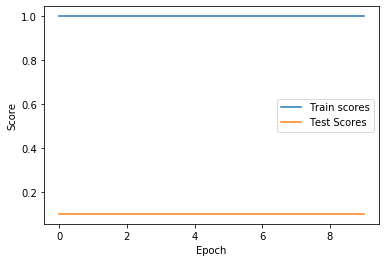

Training score is: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Test score is: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


In [21]:
# Create a visualization of results
plotScores(train_scores_bl_5sec, test_scores_bl_5sec)

print("Training score is: {0}".format(train_scores_bl_5sec))
print("Test score is: {0}".format(test_scores_bl_5sec))

In [22]:
#### Version with non-baseline 10 sec file with 5 features
# Neural Network Version 
X = pd.read_csv("feature_extraction_10sec.csv")
X.head(110)

filename   spectral_centroid      rolloff   zero_crossing_rate  \
0        blues.00000.wav         1803.133844  3874.952361               18036   
1        blues.00001.wav         1581.277785  3677.831125               11714   
2        blues.00002.wav         1507.457456  2953.071470               16165   
3        blues.00003.wav         1139.971185  2369.002071                7808   
4        blues.00004.wav         1766.557653  3382.411566               21503   
..                   ...                 ...          ...                 ...   
105  classical.00005.wav         1395.572746  2462.104447               15978   
106  classical.00006.wav         1342.758942  2491.706356               15573   
107  classical.00007.wav         1494.957943  2878.379733               17275   
108  classical.00008.wav         1511.921962  2824.696609               16511   
109  classical.00009.wav         1065.172264  2046.653517               10413   

          mfcc1       mfcc2      mfcc3      mfcc4      mfcc5      mfcc6  ...  \
0   -104.649918  122.307770 -16.163612  40.851635 -10.409742  18.029104  ...   
1   -222.168320  124.332985  11.157734  38.722603  -0.684762  27.818092  ...   
2   -100.241463  145.478943 -31.026257  36.446129 -16.617540  26.852818  ...   
3   -196.463791  147.607086   7.918547  27.065449   1.712060  17.066572  ...   
4   -174.250931  133.306839 -42.391041  27.084778 -32.371269  13.564564  ...   
..          ...         ...        ...        ...        ...        ...  ...   
105 -340.402618  135.558853 -33.810989  31.324970  -4.022440   0.232453  ...   
106 -305.833832  133.971725 -22.754091  38.675068  -5.046348   6.411022  ...   
107 -231.215240  136.595749 -28.466194  41.856594  -9.578016   7.375572  ...   
108 -301.656281  126.905128 -28.838652  39.648598  -9.574334   6.327945  ...   
109 -332.785889  153.421753  -9.929903  44.491287  -9.099988  13.402217  ...   

     chroma_pitch_d#  chroma_pitch_e  chroma_pitch_f  chroma_pitch_f#  \
0           0.258259        0.260204        0.359026         0.378731   
1           0.268387        0.234487        0.361632         0.448754   
2           0.402194        0.514248        0.325458         0.296213   
3           0.549215        0.606650        0.559762         0.461348   
4           0.218298        0.250931        0.595270         0.198476   
..               ...             ...             ...              ...   
105         0.397137        0.165235        0.252699         0.134238   
106         0.223013        0.150102        0.348308         0.185105   
107         0.464028        0.222849        0.320473         0.180397   
108         0.214683        0.154440        0.323123         0.151973   
109         0.433791        0.214247        0.149411         0.207367   

     chroma_pitch_g  chroma_pitch_g#  chroma_pitch_a  chroma_pitch_a#  \
0          0.485020         0.340910        0.325685         0.448693   
1          0.647830         0.494835        0.260851         0.227180   
2          0.261866         0.301794        0.367442         0.403937   
3          0.286164         0.250011        0.303710         0.315437   
4          0.134759         0.217967        0.333235         0.589312   
..              ...              ...             ...              ...   
105        0.289198         0.418639        0.307205         0.223452   
106        0.279377         0.308991        0.112723         0.099403   
107        0.356323         0.329285        0.241851         0.338114   
108        0.283498         0.299654        0.227941         0.214152   
109        0.341376         0.212215        0.268903         0.360292   

     chroma_pitch_b      genre  
0          0.399072      blues  
1          0.250847      blues  
2          0.643666      blues  
3          0.415873      blues  
4          0.215899      blues  
..              ...        ...  
105        0.206002  classical  
106        0.301584  classical  
107        0.120732  classical

In [23]:
# This can ONLY BE DONE ONCE, as we pop the values into a new variable to be used as predicted class
## Need to seperate genre_list variable from changes to CSV file so that it can be run each time 
genre_list = X.iloc[:, -1]
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)


# Remove the titles of each song from csv file of all songs
titles = X.pop("filename ").values
X = X.pop("genre").values

In [89]:
#### Version with non-baseline 10 sec file with 5 features
# Neural Network Version 
data = pd.read_csv("feature_extraction_10sec.csv")
print(data.shape)
#data = pd.read_csv("baseline_5sec.csv")

# Dropping unneccesary columns
data = data.drop(['filename '],axis=1)

# Encoder
genre_list = data.iloc[:, -1]
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)

#Scaler
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

len(y_train)


model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128)

test_loss, test_acc = model.evaluate(X_test,y_test)
print(test_acc)

# Create a visualization of results

# visualizing losses and accuracy
'''
train_loss = history.history['loss']
#val_loss   = history.history['val_loss']
#train_acc  = history.history['acc']
val_acc    = history.history['val_acc']
xc         = range(num_epochs)

plt.figure()
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
'''

(1000, 37)
Epoch 1/20
900/900 [==============================] - 0s 176us/step - loss: 2.1723 - accuracy: 0.2189
Epoch 2/20
900/900 [==============================] - 0s 28us/step - loss: 1.8641 - accuracy: 0.3611
Epoch 3/20
900/900 [==============================] - 0s 29us/step - loss: 1.6677 - accuracy: 0.3944
Epoch 4/20
900/900 [==============================] - 0s 29us/step - loss: 1.5152 - accuracy: 0.4344
Epoch 5/20
900/900 [==============================] - 0s 29us/step - loss: 1.3996 - accuracy: 0.5067
Epoch 6/20
900/900 [==============================] - 0s 28us/step - loss: 1.3104 - accuracy: 0.5422
Epoch 7/20
900/900 [==============================] - 0s 30us/step - loss: 1.2528 - accuracy: 0.5622
Epoch 8/20
900/900 [==============================] - 0s 31us/step - loss: 1.1836 - accuracy: 0.5867
Epoch 9/20
900/900 [==============================] - 0s 31us/step - loss: 1.1252 - accuracy: 0.6078
Epoch 10/20
900/900 [==============================] - 0s 31us/step - loss: 1.0

"\ntrain_loss = history.history['loss']\n#val_loss   = history.history['val_loss']\n#train_acc  = history.history['acc']\nval_acc    = history.history['val_acc']\nxc         = range(num_epochs)\n\nplt.figure()\nplt.plot(xc, train_loss)\nplt.plot(xc, val_loss)\nplt.plot(history.history['loss'])\nplt.plot(history.history['acc'])\nplt.title('Model loss')\nplt.ylabel('Loss')\nplt.xlabel('Epoch')\nplt.legend(['Train', 'Test'], loc='upper left')\nplt.show()\n"

In [147]:
def read_data(file_name):
    data = pd.read_csv(file_name)
    print("*BEFORE* Shape of data file \"{0}\" is: {1}".format(file_name, data.shape))
    return data

def create_genre_list(data):
    genre_list = data.iloc[:, -1]
    return genre_list

# Encoding occurs in here
def get_y_value(data):
    genre_list = create_genre_list(data)
    encoder = preprocessing.LabelEncoder()
    y = encoder.fit_transform(genre_list)
    return y

# Scaling occurs in here
def get_x_value(data):
    data = data.drop(['filename '],axis=1)
    data = data.drop(['genre'],axis=1)
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
    return X

def get_x_value_3_feature(data):
    data = data.drop(['filename '],axis=1)
    data = data.drop(['genre'],axis=1)
    data = data.drop(['rolloff '], axis=1)
    data = data.drop(['zero_crossing_rate'], axis=1)
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
    print("*AFTR* Shape of data file is: {0}".format(data.shape))
    return X

def get_baseline_file_names():
    return {"baseline_5sec.csv",
            "baseline_10sec.csv",
            "baseline_20sec.csv"}

def get_5_feature_file_names():
    return {"feature_extraction_5sec.csv",
            "feature_extraction_10sec.csv",
            "feature_extraction_20sec.csv"}

def create_and_run_nn(X_train, X_test, y_train, y_test):
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    hist = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128)

    # Get Accuracy
    test_loss, test_acc = model.evaluate(X_test,y_test)
    print(test_acc)

def train_and_eval(files):
    # Generates the results for Baseline and 5 feature NN with same hyperparameter setup
    for file in files:
        data = read_data(file)
        y = get_y_value(data)
        X = get_x_value(data)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
        create_and_run_nn(X_train, X_test, y_train, y_test)

def train_and_eval_3_features(files):
    for file in files:
        data = read_data(file)
        y = get_y_value(data)
        X = get_x_value_3_feature(data)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
        create_and_run_nn(X_train, X_test, y_train, y_test)

def run_all_nn_main():
    files_baseline = get_baseline_file_names()
    files_5_features = get_5_feature_file_names()
    
    train_and_eval(files_baseline)
    train_and_eval_3_features(files_5_features)
    train_and_eval(files_5_features)



In [148]:
run_all_nn_main()

*BEFORE* Shape of data file "baseline_10sec.csv" is: (1000, 432)
Epoch 1/20
900/900 [==============================] - 0s 181us/step - loss: 2.4134 - accuracy: 0.1078
Epoch 2/20
900/900 [==============================] - 0s 39us/step - loss: 2.0576 - accuracy: 0.1978
Epoch 3/20
900/900 [==============================] - 0s 35us/step - loss: 1.8656 - accuracy: 0.3478
Epoch 4/20
900/900 [==============================] - 0s 37us/step - loss: 1.6916 - accuracy: 0.5300
Epoch 5/20
900/900 [==============================] - 0s 38us/step - loss: 1.5288 - accuracy: 0.6411
Epoch 6/20
900/900 [==============================] - 0s 33us/step - loss: 1.3864 - accuracy: 0.6889
Epoch 7/20
900/900 [==============================] - 0s 37us/step - loss: 1.2558 - accuracy: 0.7367
Epoch 8/20
900/900 [==============================] - 0s 34us/step - loss: 1.1340 - accuracy: 0.7733
Epoch 9/20
900/900 [==============================] - 0s 36us/step - loss: 0.9985 - accuracy: 0.8233
Epoch 10/20
900/900 [====

900/900 [==============================] - 0s 22us/step - loss: 1.0051 - accuracy: 0.6611
Epoch 11/20
900/900 [==============================] - 0s 23us/step - loss: 0.9789 - accuracy: 0.6756
Epoch 12/20
900/900 [==============================] - 0s 24us/step - loss: 0.9335 - accuracy: 0.6744
Epoch 13/20
900/900 [==============================] - 0s 23us/step - loss: 0.8900 - accuracy: 0.7011
Epoch 14/20
900/900 [==============================] - 0s 21us/step - loss: 0.8769 - accuracy: 0.7144
Epoch 15/20
900/900 [==============================] - 0s 21us/step - loss: 0.8234 - accuracy: 0.7289
Epoch 16/20
900/900 [==============================] - 0s 24us/step - loss: 0.7858 - accuracy: 0.7433
Epoch 17/20
900/900 [==============================] - 0s 22us/step - loss: 0.7632 - accuracy: 0.7578
Epoch 18/20
900/900 [==============================] - 0s 22us/step - loss: 0.7188 - accuracy: 0.7744
Epoch 19/20
900/900 [==============================] - 0s 23us/step - loss: 0.7056 - accuracy: